# Battle of the LA Cities
### IBM Coursera Capstone Project

## Introduction

**Ice cream is America’s favorite dessert. According to [IDFA](https://www.idfa.org/ice-cream-sales-trends), the average American consumes more than 23 pounds of ice cream per year. With consumption levels this high, an ice cream business is bound to bring in massive profit.**

**Due to its high population and scorching summer heat, Los Angeles (LA) County is an ideal place for entrepreneurs to start an ice cream shop.  However, LA County stretches far, and a subpar business location will result in low revenue at best. This project will demonstrate the best cities within LA county for starting an ice cream business.**

**The project is dedicated to stakeholders who are interested in starting an ice cream business, but are unable to decide on the location. After reviewing the results, stakeholders can confidently take one step forward into starting their business.**

**Import libraries**

In [1]:
# API Keys
import Keys

# library for linear algrebra
import numpy as np

# library for dataframe and its manipulation
import pandas as pd

# library for statistical methods
from scipy import stats 

# regular expressions to clean data
import re

#libraries to retrieve data
import requests
from bs4 import BeautifulSoup
import censusdata
# library to get coordinates
import geocoder

# library for normalization
from sklearn.preprocessing import MinMaxScaler

#machine learning
from sklearn.cluster import KMeans

#libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.cm as cm
import matplotlib.colors as colors
import branca
import folium
%matplotlib inline

#library to ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Data Acquisition

**The dataset is obtained through various scraping techniques and APIs.**
* _**city:**_ The city name is obtained from Wikipedia by connecting to the web page and scrapping the desired data using BeautifulSoup.
* _**population:**_ The census code for the state and each city in LA county is retrieved using the Censusdata library. Using the census codes, the population data is obtained using the US Census API. The data type is changed to integer.
* _**income:**_ The income data is collected by the same method used to get the population data. Similarly, the data type is also changed to integer.
* _**latitude & longitude:**_ The city coordinates are retrieved using Google's API.
* _**area:**_ Each city land area is obtained by connecting to Wikipedia's web page and scrapping the desired data using BeautifulSoup. If present, commas are removed and the data type is changed to float.
* _**radius:**_ The radius is calculated from the land area using the Area of a Circle formula.
* _**mean:**_ The Foursquare API is utilized to search for dessert shops within the radius of each city coordinate. The category type is returned for each venue and converted into dummy variables. The number of ice cream shops are then divided by the total number of dessert venues.

In [2]:
def scrape(url):
    
    r = requests.get(url)
    html = r.content
    soup = BeautifulSoup(html, 'html.parser')
    
    return soup

In [3]:
link = 'https://en.wikipedia.org/wiki/List_of_cities_in_Los_Angeles_County,_California'
page = scrape(link) 

In [4]:
list_of_cities = []

table = page.find('tbody')
for data in table.find_all('td'):
    for tag in data.find_all('a'):
        list_of_cities.append(tag.get_text())

In [5]:
state_code_dict = censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2018)
state_code_dict['California']

censusgeo((('state', '06'),))

In [6]:
def find_population(city_name):
    
    city_code_dict = censusdata.geographies(censusdata.censusgeo([('state', '06'),('place', '*')]), 'acs5', 2018)
    place_code = city_code_dict[city_name + ' city, California'].params()[1][1]
    
    url = 'https://api.census.gov/data/2018/acs/acs5/profile?get=DP05_0001E&for=place:{}&in=state:06&key={}'.format(
        place_code, Keys.CENSUS_KEY)
    
    r = requests.get(url)
    
    return r.json()[1][0] 

In [7]:
list_of_population = [find_population(city) for city in list_of_cities]

In [8]:
def find_income(city_name):
    
    city_code_dict = censusdata.geographies(censusdata.censusgeo([('state', '06'),('place', '*')]), 'acs5', 2018)
    place_code = city_code_dict[city_name + ' city, California'].params()[1][1]
    
    url = 'https://api.census.gov/data/2018/acs/acs5/profile?get=DP03_0062E&for=place:{}&in=state:06&key={}'.format(place_code, Keys.CENSUS_KEY)
    
    r = requests.get(url)
    
    return r.json()[1][0] 

In [9]:
list_of_income = [find_income(city) for city in list_of_cities]

In [10]:
LA = pd.DataFrame({'city': list_of_cities, 'population': list_of_population, 'income': list_of_income})
LA.head()

,city,population,income
0,Agoura Hills,20636,121896
1,Alhambra,84974,57117
2,Arcadia,58207,92102
3,Artesia,16817,63708
4,Avalon,3763,69440


In [11]:
LA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 3 columns):
city          88 non-null object
population    88 non-null object
income        88 non-null object
dtypes: object(3)
memory usage: 2.2+ KB


In [12]:
LA.population = LA.population.astype('int')
LA.income = LA.income.astype('int')

In [13]:
def find_coord(name):
    g = geocoder.google('{}, California'.format(name), key = Keys.API_KEY)
    latitude, longitude = g.latlng
    
    return latitude, longitude

In [14]:
LA['latitude'] = [find_coord(name)[0] for name in LA.city]
LA['longitude'] = [find_coord(name)[1] for name in LA.city]

In [15]:
link = 'https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_California#cite_note-Census_2010-1'
page = scrape(link)

In [16]:
list_of_area = []

table = page.find('table', attrs = {'class': 'wikitable plainrowheaders sortable'})

for tag in table.find_all('th', attrs = {'scope': 'row'}):
    list_of_cities.append(tag.get_text().rstrip())
for area in table.find_all('td')[4::6]:
    list_of_area.append(area.get_text().rstrip())

In [17]:
area_df = pd.DataFrame({'city': list_of_cities, 'area': list_of_area})
area_df.head()

,city,area
0,Adelanto,145.1
1,Agoura Hills,20.2
2,Alameda,27.5
3,Albany,4.6
4,Alhambra,19.8


In [18]:
LA = LA.merge(area_df)
LA.head()

,city,population,income,latitude,longitude,area
0,Agoura Hills,20636,121896,34.153340,-118.761676,20.2
1,Alhambra,84974,57117,34.095287,-118.127015,19.8
2,Arcadia,58207,92102,34.139729,-118.035345,28.3
3,Artesia,16817,63708,33.865848,-118.083121,4.2
4,Avalon,3763,69440,33.342819,-118.328228,7.6


In [19]:
LA['area'].dtype

dtype('O')

In [20]:
for area in LA['area']:
    try:
        float(area)
    except:
        print(area)

1,213.8


In [21]:
for val in LA['area']:
    corrected_val = re.sub(',', '', val)
    LA.loc[LA['area'] == val, 'area'] = corrected_val

In [22]:
LA.area = LA.area.astype('float')

In [23]:
def find_radius(area):
    
    r = np.sqrt(area / np.pi)
    r = r * 1000 # convert to meters
    
    return r.round(decimals = 2)

In [24]:
LA['radius'] = [find_radius(area) for area in LA.area]
LA.head()

,city,population,income,latitude,longitude,area,radius
0,Agoura Hills,20636,121896,34.153340,-118.761676,20.2,2535.72
1,Alhambra,84974,57117,34.095287,-118.127015,19.8,2510.49
2,Arcadia,58207,92102,34.139729,-118.035345,28.3,3001.36
3,Artesia,16817,63708,33.865848,-118.083121,4.2,1156.24
4,Avalon,3763,69440,33.342819,-118.328228,7.6,1555.36


In [25]:
LA.isnull().sum()

city          0
population    0
income        0
latitude      0
longitude     0
area          0
radius        0
dtype: int64

In [26]:
CLIENT_ID = Keys.CLIENT_ID
CLIENT_SECRET = Keys.CLIENT_SECRET
VERSION = '20180605'
CATEGORY_ID = '4bf58dd8d48988d1d0941735' # Foursquare category ID for dessert shops

In [27]:
def getCategories(cities, radius, latitudes, longitudes, ID, LIMIT):
    category_list = []
    
    for city, r, lat, lng in zip(cities, radius, latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            lat,
            lng,
            VERSION,
            ID,
            r, 
            LIMIT)
        
        results = requests.get(url).json()['response']['venues']
        
        if results == []:
            category_list.append([city, 'None'])
        else:
            for d in results:
                cat_dict = d['categories']
                for cat_type in cat_dict:
                    category_list.append([city, cat_type['name']])
                
    category_df = pd.DataFrame({'city': [item[0] for item in category_list],
                                'category': [item[1] for item in category_list]})
    
    return category_df       

In [28]:
categories = getCategories(LA.city, LA.radius, LA.latitude, LA.longitude, CATEGORY_ID, 50)
categories.shape

(1728, 2)

In [29]:
onehot = pd.get_dummies(categories['category'])
onehot['city'] = categories['city']

grouped_mean = onehot.groupby('city').mean()

df_to_keep = grouped_mean[['Ice Cream Shop']]
df_to_keep.rename(columns = {'Ice Cream Shop': 'mean'}, inplace = True)

In [30]:
LA = LA.merge(df_to_keep, left_on = 'city', right_index = True)
LA.head()

,city,population,income,latitude,longitude,area,radius,mean
0,Agoura Hills,20636,121896,34.153340,-118.761676,20.2,2535.72,0.333333
1,Alhambra,84974,57117,34.095287,-118.127015,19.8,2510.49,0.295455
2,Arcadia,58207,92102,34.139729,-118.035345,28.3,3001.36,0.428571
3,Artesia,16817,63708,33.865848,-118.083121,4.2,1156.24,0.382353
4,Avalon,3763,69440,33.342819,-118.328228,7.6,1555.36,0.750000


## Methodology

**The population, income, and mean data are visualized.**

In [31]:
def viz(data,col):
    top_five = data.sort_values(by = col, ascending = False)[0:5]
    top_five['city'] = top_five['city'].apply(lambda name: re.match('\S+\s*\S*', name).group())
    bot_five = data.sort_values(by = col, ascending = True)[0:5]
    bot_five['city'] = bot_five['city'].apply(lambda name: re.match('\S+\s*\S*', name).group())
    
    fig, axs = plt.subplots(ncols = 2, figsize = (15,6))
   
    sns.barplot(x = 'city', y = col, data = top_five, palette = 'GnBu_d', ax = axs[0])
    axs[0].set_xticklabels(labels = top_five['city'])
    axs[0].set_xlabel('')
    axs[0].set_ylabel(ylabel = col, fontsize = 13, weight = 'bold')
    axs[0].set_title(str(col).capitalize() + ': Top Five Cities', fontsize = 15, weight = 'bold', pad = 15)
    
    sns.barplot(x = 'city', y = col, data = bot_five, palette = 'GnBu_d', ax = axs[1])
    axs[1].set_xticklabels(labels = bot_five['city'])
    axs[1].set_xlabel('')
    axs[1].set_ylabel(col, fontsize = 13, weight = 'bold')
    axs[1].set_title(str(col).capitalize() + ': Bottom Five Cities', fontsize = 15, weight = 'bold', pad = 15)
    
    fig.tight_layout(pad = 3.0)

In [32]:
sns.set(style = 'darkgrid')

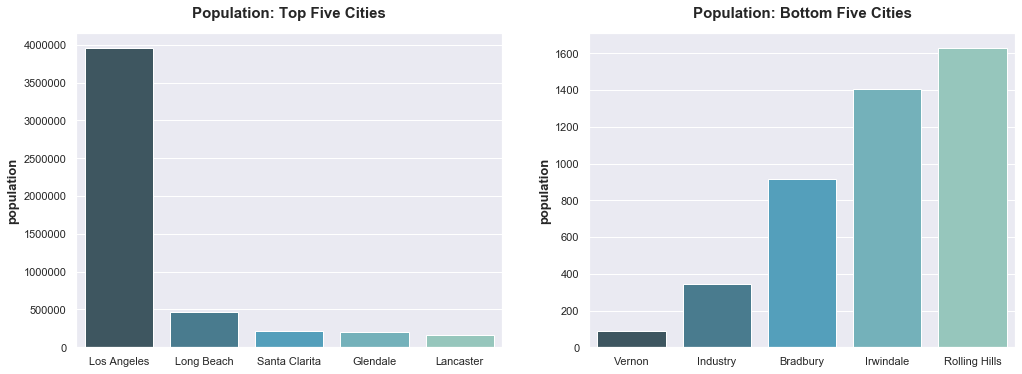

In [33]:
viz(LA,'population')

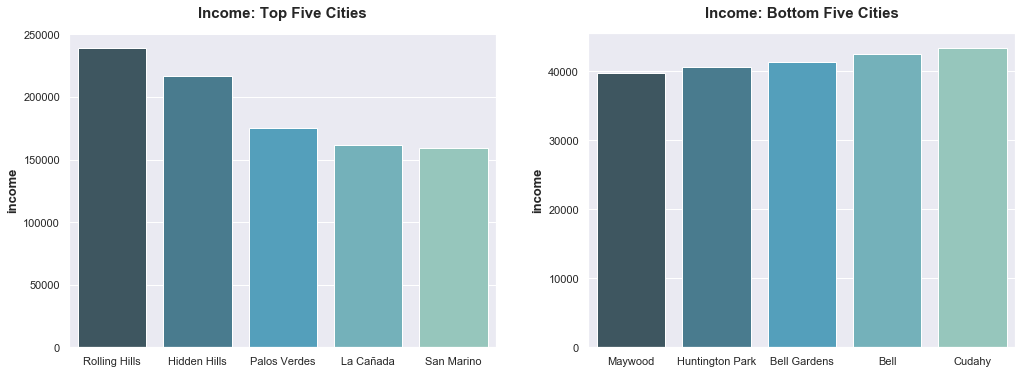

In [34]:
viz(LA,'income')

In [35]:
def plot_scatter(data):
    no_outlier_df = data[data['population'] < data['population'].max()]
    low_mean = no_outlier_df[no_outlier_df['mean'] <= 0.50]
    high_mean = no_outlier_df[no_outlier_df['mean'] > 0.5]
    high_pop = data[data['population'] == data['population'].max()]
    
    low_mean_range = (low_mean['mean'].min(), low_mean['mean'].max())
    high_mean_range = (high_mean['mean'].min(), high_mean['mean'].max())
    high_pop_mean = high_pop['mean'].values[0]
    
    fig, axs = plt.subplots(ncols = 3, figsize = (20,6))
    
    axs[0].scatter(x = 'population', y = 'income', data = low_mean)
    axs[0].text(x = 361000, y = 233000, s = 'Mean: {}-{}'.format(low_mean_range[0],low_mean_range[1]),
                fontsize = 13, weight = 'bold')
    axs[0].annotate('', xy = (220000,97000), xytext = (370000,147000), 
                arrowprops=dict(arrowstyle = '->', color = 'black'))
    axs[0].set_xlabel(xlabel = 'population', fontsize = 13, weight = 'bold')
    axs[0].set_ylabel(ylabel = 'income', fontsize = 13, weight = 'bold')
    axs[0].set_title('Low Mean: Relationship between Population & Income', fontsize = 15, weight = 'bold', pad = 15)
    
    axs[1].scatter(x = 'population', y = 'income', data = high_mean)
    axs[1].text(x = 82000, y = 171000, s = 'Mean: {}-{}'.format(round(high_mean_range[0], 2), high_mean_range[1]),
                fontsize = 13, weight = 'bold')
    axs[1].annotate('', xy = (22000,135000), xytext = (40000,100000),
                    arrowprops=dict(arrowstyle = '->', color = 'black'))
    axs[1].set_xlabel(xlabel = 'population', fontsize = 13, weight = 'bold')
    axs[1].set_ylabel(ylabel = 'income', fontsize = 13, weight = 'bold')
    axs[1].set_title('High Mean: Relationship between Population & Income', fontsize = 15, weight = 'bold', pad = 15)
    
    axs[2].scatter(x = 'population', y = 'income', data = high_pop)
    axs[2].text(x = 4250000, y = 67000, s = 'Mean: ' + str(high_pop_mean), fontsize = 13, weight = 'bold')
    axs[2].set_xlim(high_pop['population'].values - 500000, high_pop['population'].values + 500000)
    axs[2].set_ylim(high_pop['income'].values - 10000, high_pop['income'].values + 10000)
    axs[2].set_xlabel(xlabel = 'population', fontsize = 13, weight = 'bold')
    axs[2].set_ylabel(ylabel = 'income', fontsize = 13, weight = 'bold')
    axs[2].set_title(str(high_pop['city'].values[0]) + ' City: Relationship between Population & Income',
                     fontsize = 15, weight = 'bold', pad = 15)
    
    
    fig.tight_layout(pad = 3.0)

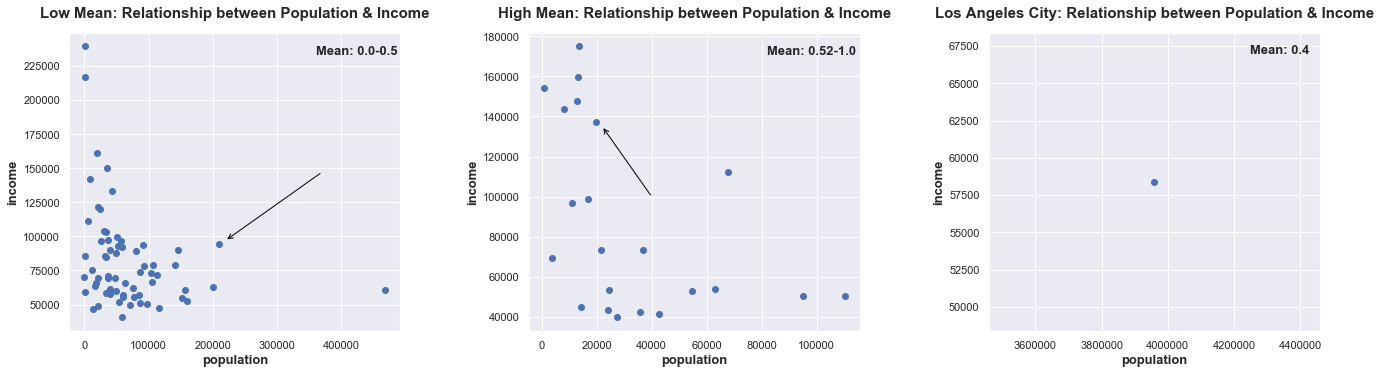

In [36]:
plot_scatter(LA)

**The population and income data are then transformed using Box-Cox transformation and normalized using the Min-Max method.**

In [37]:
def transformation(series):
    Q1_norm = series.quantile(.25)
    Q3_norm = series.quantile(.75)
    IQR_norm = Q3_norm - Q1_norm
    low_out_norm = Q1_norm - 1.5 * IQR_norm
    high_out_norm = Q3_norm + 1.5 * IQR_norm
    num_out_norm = sum(series < low_out_norm) + sum(series > high_out_norm)
    
    tf,_ = stats.boxcox(series)
    tf_series = pd.Series(tf)
    Q1_tf = tf_series.quantile(.25)
    Q3_tf = tf_series.quantile(.75)
    IQR_tf = Q3_tf - Q1_tf
    low_out_tf = Q1_tf - 1.5 * IQR_tf
    high_out_tf = Q3_tf + 1.5 * IQR_tf
    num_out_tf = sum(tf_series < low_out_tf) + sum(tf_series > high_out_tf)
    
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (20,10))
    
    sns.boxplot(y = series, ax = axs[0][0])
    axs[0][0].set_title('Boxplot: Before Transformation', fontsize = 15, weight = 'bold')
    axs[0][0].set_ylabel('')
    axs[0][0].text(s ='Number of outliers: {}'.format(num_out_norm),
                   x = 0.72, y = 0.9,
                   transform = axs[0][0].transAxes)
    sns.distplot(series, ax = axs[1][0])
    axs[1][0].set_title('Distribution: Before Transformation', fontsize = 15, weight = 'bold')
    axs[1][0].set_xlabel('')
    axs[1][0].text(s = 'Kurtosis: {}'.format(series.kurtosis().round(decimals = 2)),
                   x = 0.80, y = 0.9,
                   transform = axs[1][0].transAxes)
    
    sns.boxplot(y = tf_series, ax = axs[0][1])
    axs[0][1].set_title('Boxplot: After Transformation', fontsize = 15, weight = 'bold')
    axs[0][1].text(s = 'Number of outliers: {}'.format(num_out_tf),
                   x = 0.72, y = 0.9,
                   transform = axs[0][1].transAxes)
    sns.distplot(tf_series, ax = axs[1][1])
    axs[1][1].set_title('Distribution: After Transformation', fontsize = 15, weight = 'bold')
    axs[1][1].text(s = 'Kurtosis: {}'.format(tf_series.kurtosis().round(decimals = 2)),
                   x = 0.80, y = 0.9,
                   transform = axs[1][1].transAxes)
    
    fig.tight_layout(pad = 3.0)

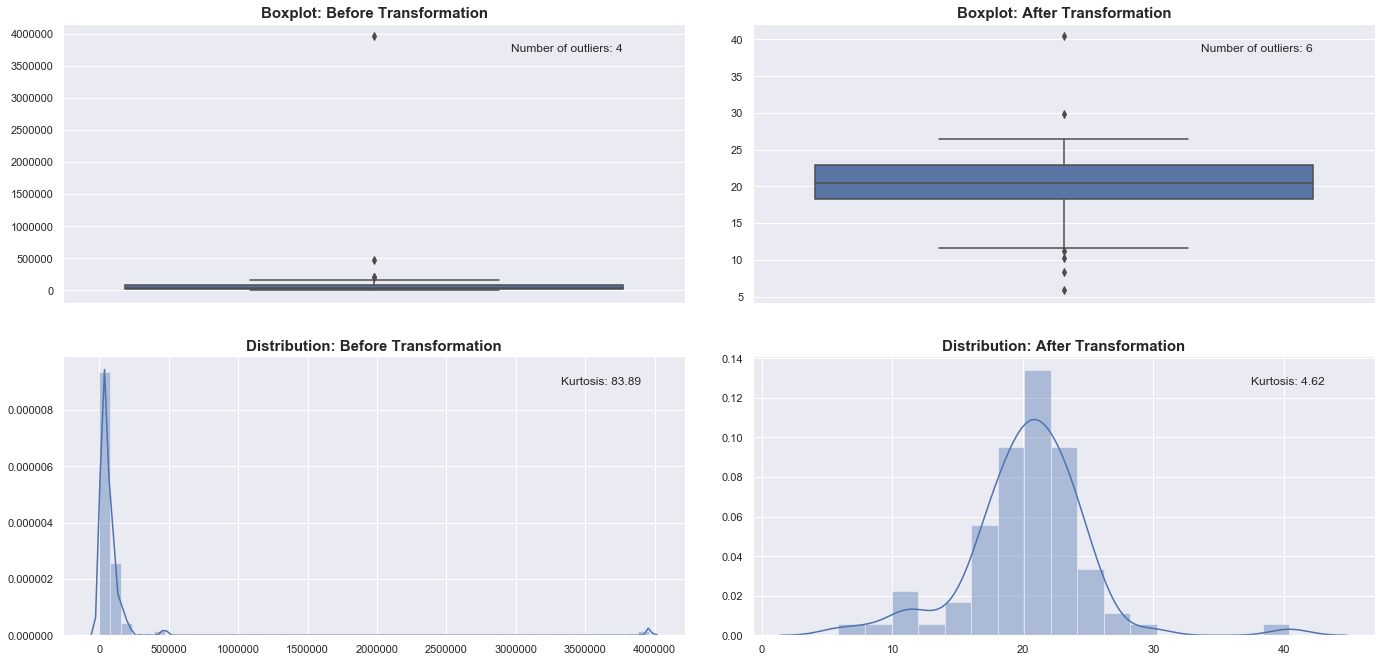

In [38]:
transformation(LA.population)

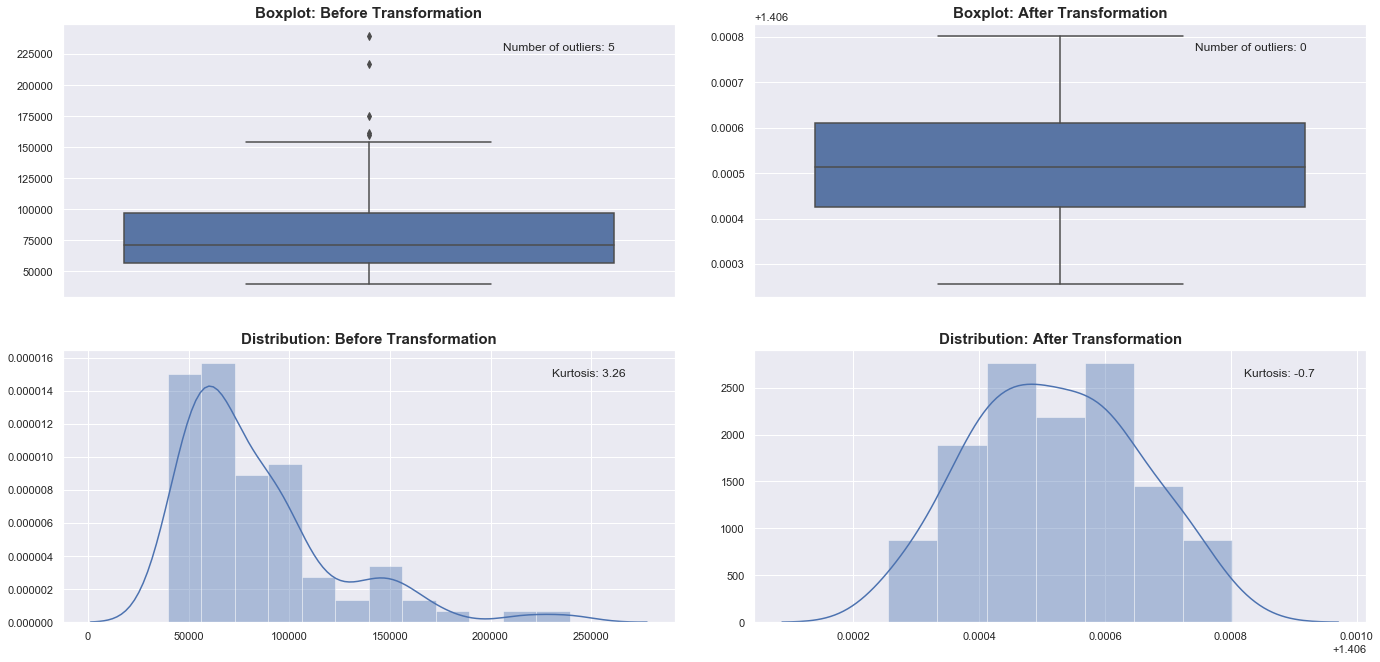

In [39]:
transformation(LA.income)

In [40]:
tf_data = LA[['population', 'income']].apply(lambda x : stats.boxcox(x)[0])

In [41]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(tf_data)
X = pd.DataFrame(data = scaled_data, index = LA.city, columns = ['population', 'income'])
X = X.merge(df_to_keep, left_index = True, right_index = True)
X

,population,income,mean
city,,,
Agoura Hills,0.361289,0.761734,0.333333
Alhambra,0.497829,0.315272,0.295455
Arcadia,0.459165,0.623888,0.428571
Artesia,0.343292,0.395318,0.382353
Avalon,0.223555,0.454225,0.750000
...,...,...,...
Walnut,0.395314,0.687485,0.375000
West Covina,0.522448,0.537013,0.400000
West Hollywood,0.413392,0.452397,0.388889


**The optimal number of clusters is obtained by using the elbow method.**

In [42]:
def elbow_viz(df):
    clus = []
    iner = []

    for i in range(1,11) :
        km = KMeans(n_clusters = i, random_state = 8)
        km.fit(df)
        iner.append(km.inertia_)
        clus.append(i)
    
    fig = plt.figure(figsize = (4,5))

    plt.plot(clus,iner,marker = '.')
    
    plt.xticks(clus)
    plt.xlabel('Number of Cluster', fontsize = 12)
    plt.ylabel('Inertia', fontsize = 12)

    fig.suptitle('Elbow Method',fontsize = 15)
    fig.tight_layout(pad = 3.0)   

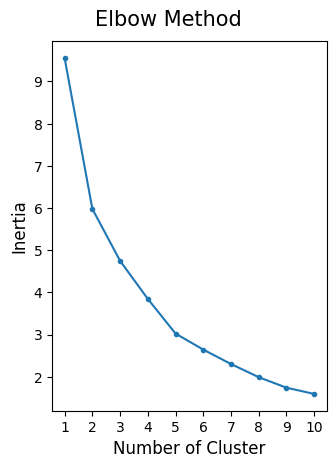

In [43]:
sns.reset_orig()
elbow_viz(X)

## Results

**The cities are segmented into 5 clusters.**  
**Using a Folium map, a marker is plotted on each city's coordinate. The markers are colored differently dependent on the cluster they belong to.   
To view each cluster's characteristics, a dataframe containing the population, income, and mean minimum and maximum values is created.**

In [44]:
kclusters = 5
model = KMeans(n_clusters = kclusters)
clusters = model.fit_predict(X)

In [45]:
LA['cluster'] = clusters
LA.head()

,city,population,income,latitude,longitude,area,radius,mean,cluster
0,Agoura Hills,20636,121896,34.153340,-118.761676,20.2,2535.72,0.333333,4
1,Alhambra,84974,57117,34.095287,-118.127015,19.8,2510.49,0.295455,1
2,Arcadia,58207,92102,34.139729,-118.035345,28.3,3001.36,0.428571,2
3,Artesia,16817,63708,33.865848,-118.083121,4.2,1156.24,0.382353,1
4,Avalon,3763,69440,33.342819,-118.328228,7.6,1555.36,0.750000,0


In [46]:
county_name = 'Los Angeles County'
la_lat, la_lng = find_coord(county_name)

print('The geographical coordinate of {} is {}, {}.'.format(county_name, round(la_lat, 4), round(la_lng, 4)))

The geographical coordinate of Los Angeles County is 34.0522, -118.2437.


**Note: To see map, please click [here](https://nbviewer.jupyter.org/github/Ericjung008/Coursera_Capstone/blob/master/Week%205/Battle-of-the-LA-Cities.ipynb).**

In [47]:
map_clusters = folium.Map(location=[la_lat, la_lng], zoom_start=9)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gnuplot(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

colormap = branca.colormap.LinearColormap(colors = rainbow[:5], index = x, vmin = 0, vmax = 4)
colormap.add_to(map_clusters)

sw = LA[['latitude', 'longitude']].min().values.tolist()
ne = LA[['latitude','longitude']].max().values.tolist()

map_clusters.fit_bounds([sw, ne])

d = {}
pos = 0
for clus in x:
    d[clus] = rainbow[pos]
    pos += 1
    
markers_colors = []
for lat, lng, name, clus in zip(LA.latitude, LA.longitude, LA.city, LA.cluster):
    label = folium.Popup(name + '<br> Cluster ' + str(clus))
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=d[clus],
        fill=True,
        fill_color=d[clus],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

In [48]:
min_max_table = LA.groupby('cluster').agg({'population': ('min','max'), 
                                           'income': ('min','max'),
                                           'mean': ('min', 'max')})

min_max_table

population          income              mean          
               min      max    min     max       min       max
cluster                                                       
0              916    67700  69440  175000  0.500000  0.800000
1             1405  3959657  47083   73517  0.000000  0.500000
2            17791   209478  65518  133286  0.266667  0.545455
3            14411   115669  39738   53677  0.380952  1.000000
4               90    25824  70000  239375  0.000000  0.416667

## Discussion

**Insight on each cluster is shown below:**
* _**cluster 0:**_ low-decent population, medium-high income, medium-high percent of ice cream shops.
    * Set up an ice cream shop in these cities if the ice cream quality will outcompete other shops'. 
      
* _**cluster 1:**_ decent-high population, but low income. There are an average amount of established ice cream shops at most.  
    * If the goal is to sell affordable ice cream, then build a shop in this cluster's cities.
* _**cluster 2:**_ decent population, medium to medium-high income, and low to medium percent of ice cream shops.
    * Ideal place to set up an ice cream shop.
* _**cluster 3:**_ decent population, but low income. The competetion can also get tough. 
    * Avoid starting an ice cream business in these cities.   
* _**cluster 4:**_ low population, medium-high income, and low-medium percent of ice cream shops.
    * Start a business in these cities if premium ice creams will be on the menu. Think Serendipity 3.

## Conclusion

**Ice cream businesses have the ability to bring in high cash flow. LA County is a great place to start an ice cream shop due to the county’s high population and extreme summer heat. However, an ice cream parlor in a poor location can result in bankruptcy. Therefore, population, resident income, and the percentage of ice cream businesses for each city in LA county were obtained. The data was used to cluster similar cities. After analyzing each cluster’s characteristics, cities within cluster 2 was determined to be the ideal locations to start an ice cream business.**